## Analyzing keio plate 9

This notebook runs the analysis pipeline for the data for Keio plate 9_1 collected on 08032017.

In [1]:
#Import packages
import numpy as np 
import os
import tifffile as tiff
from skimage.io import imread
from skimage.measure import label, regionprops
import scipy
import matplotlib.pyplot as plt
import cPickle as pickle
from SLIP_functions import analyze_well, analyze_plate, segment_SLIP, plot_slip_well, plot_slip_wells
from SLIP_functions import plot_slip_joint_plot, fit_kde, compute_p_values, classify_infections_gmm
from SLIP_functions import classify_infections, compute_p_lysis_posterior, compute_MOI_posterior, plot_slip_wells_gmm
from keio_names import get_keio_names, pos_to_strain
import seaborn as sns
import pandas as pd
import pymc3 as pm

sns.set_context('notebook', font_scale = 1.1)
sns.set_style('white')
sns.set_style('ticks')

#Activate matplotlib inline
%matplotlib inline

#Define root directory path
root_direc = '/media/vanvalen/fe0ceb60-f921-4184-a484-b7de12c1eea6/keio_screen/08.03.2017/keio9_1/'
plate_number = 9

#Define directory path to infection data (all positions)
data_direc = os.path.join(root_direc, 'data')

#Define directory path to control data (all positions)
control_direc = os.path.join(root_direc, 'control')

#Define directory path to where you want to store neural net outputs. 
#mask directories must exist at run time!
mask_direc = os.path.join(root_direc, 'masks')
control_mask_direc = os.path.join(root_direc,'control_masks')

tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


In [2]:
#Define which wells were used
row_control = ['A']
col_control = [12]

row_data = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
col_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [3]:
#Load saved data
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
mean_FITC = pickle.load(open(mean_FITC_name, 'rb'))
mean_cherry = pickle.load(open(mean_cherry_name, 'rb'))

mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
mean_FITC_control = pickle.load(open(mean_FITC_control_name, 'rb'))
mean_cherry_control = pickle.load(open(mean_cherry_control_name, 'rb'))

p_values_dict_name = os.path.join(root_direc, 'p_values_dict.pkl')
p_values_dict = pickle.load(open(p_values_dict_name, 'rb'))

(3690, 2)


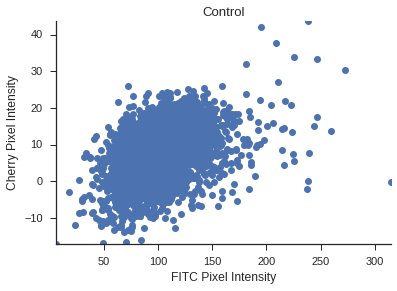

In [4]:
#Plot the data from the control plate
plot_slip_well(mean_FITC_control, mean_cherry_control, well = 'A12', title = 'Control')
sns.despine()

data_control = np.stack([mean_FITC_control['A12'], mean_cherry_control['A12']], axis = 1)
print data_control.shape

/home/vanvalen/.pyenv/versions/2.7.4/envs/DeepCell/lib/python2.7/site-packages/openpyxl/reader/worksheet.py:310: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


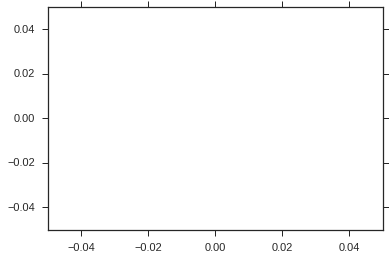

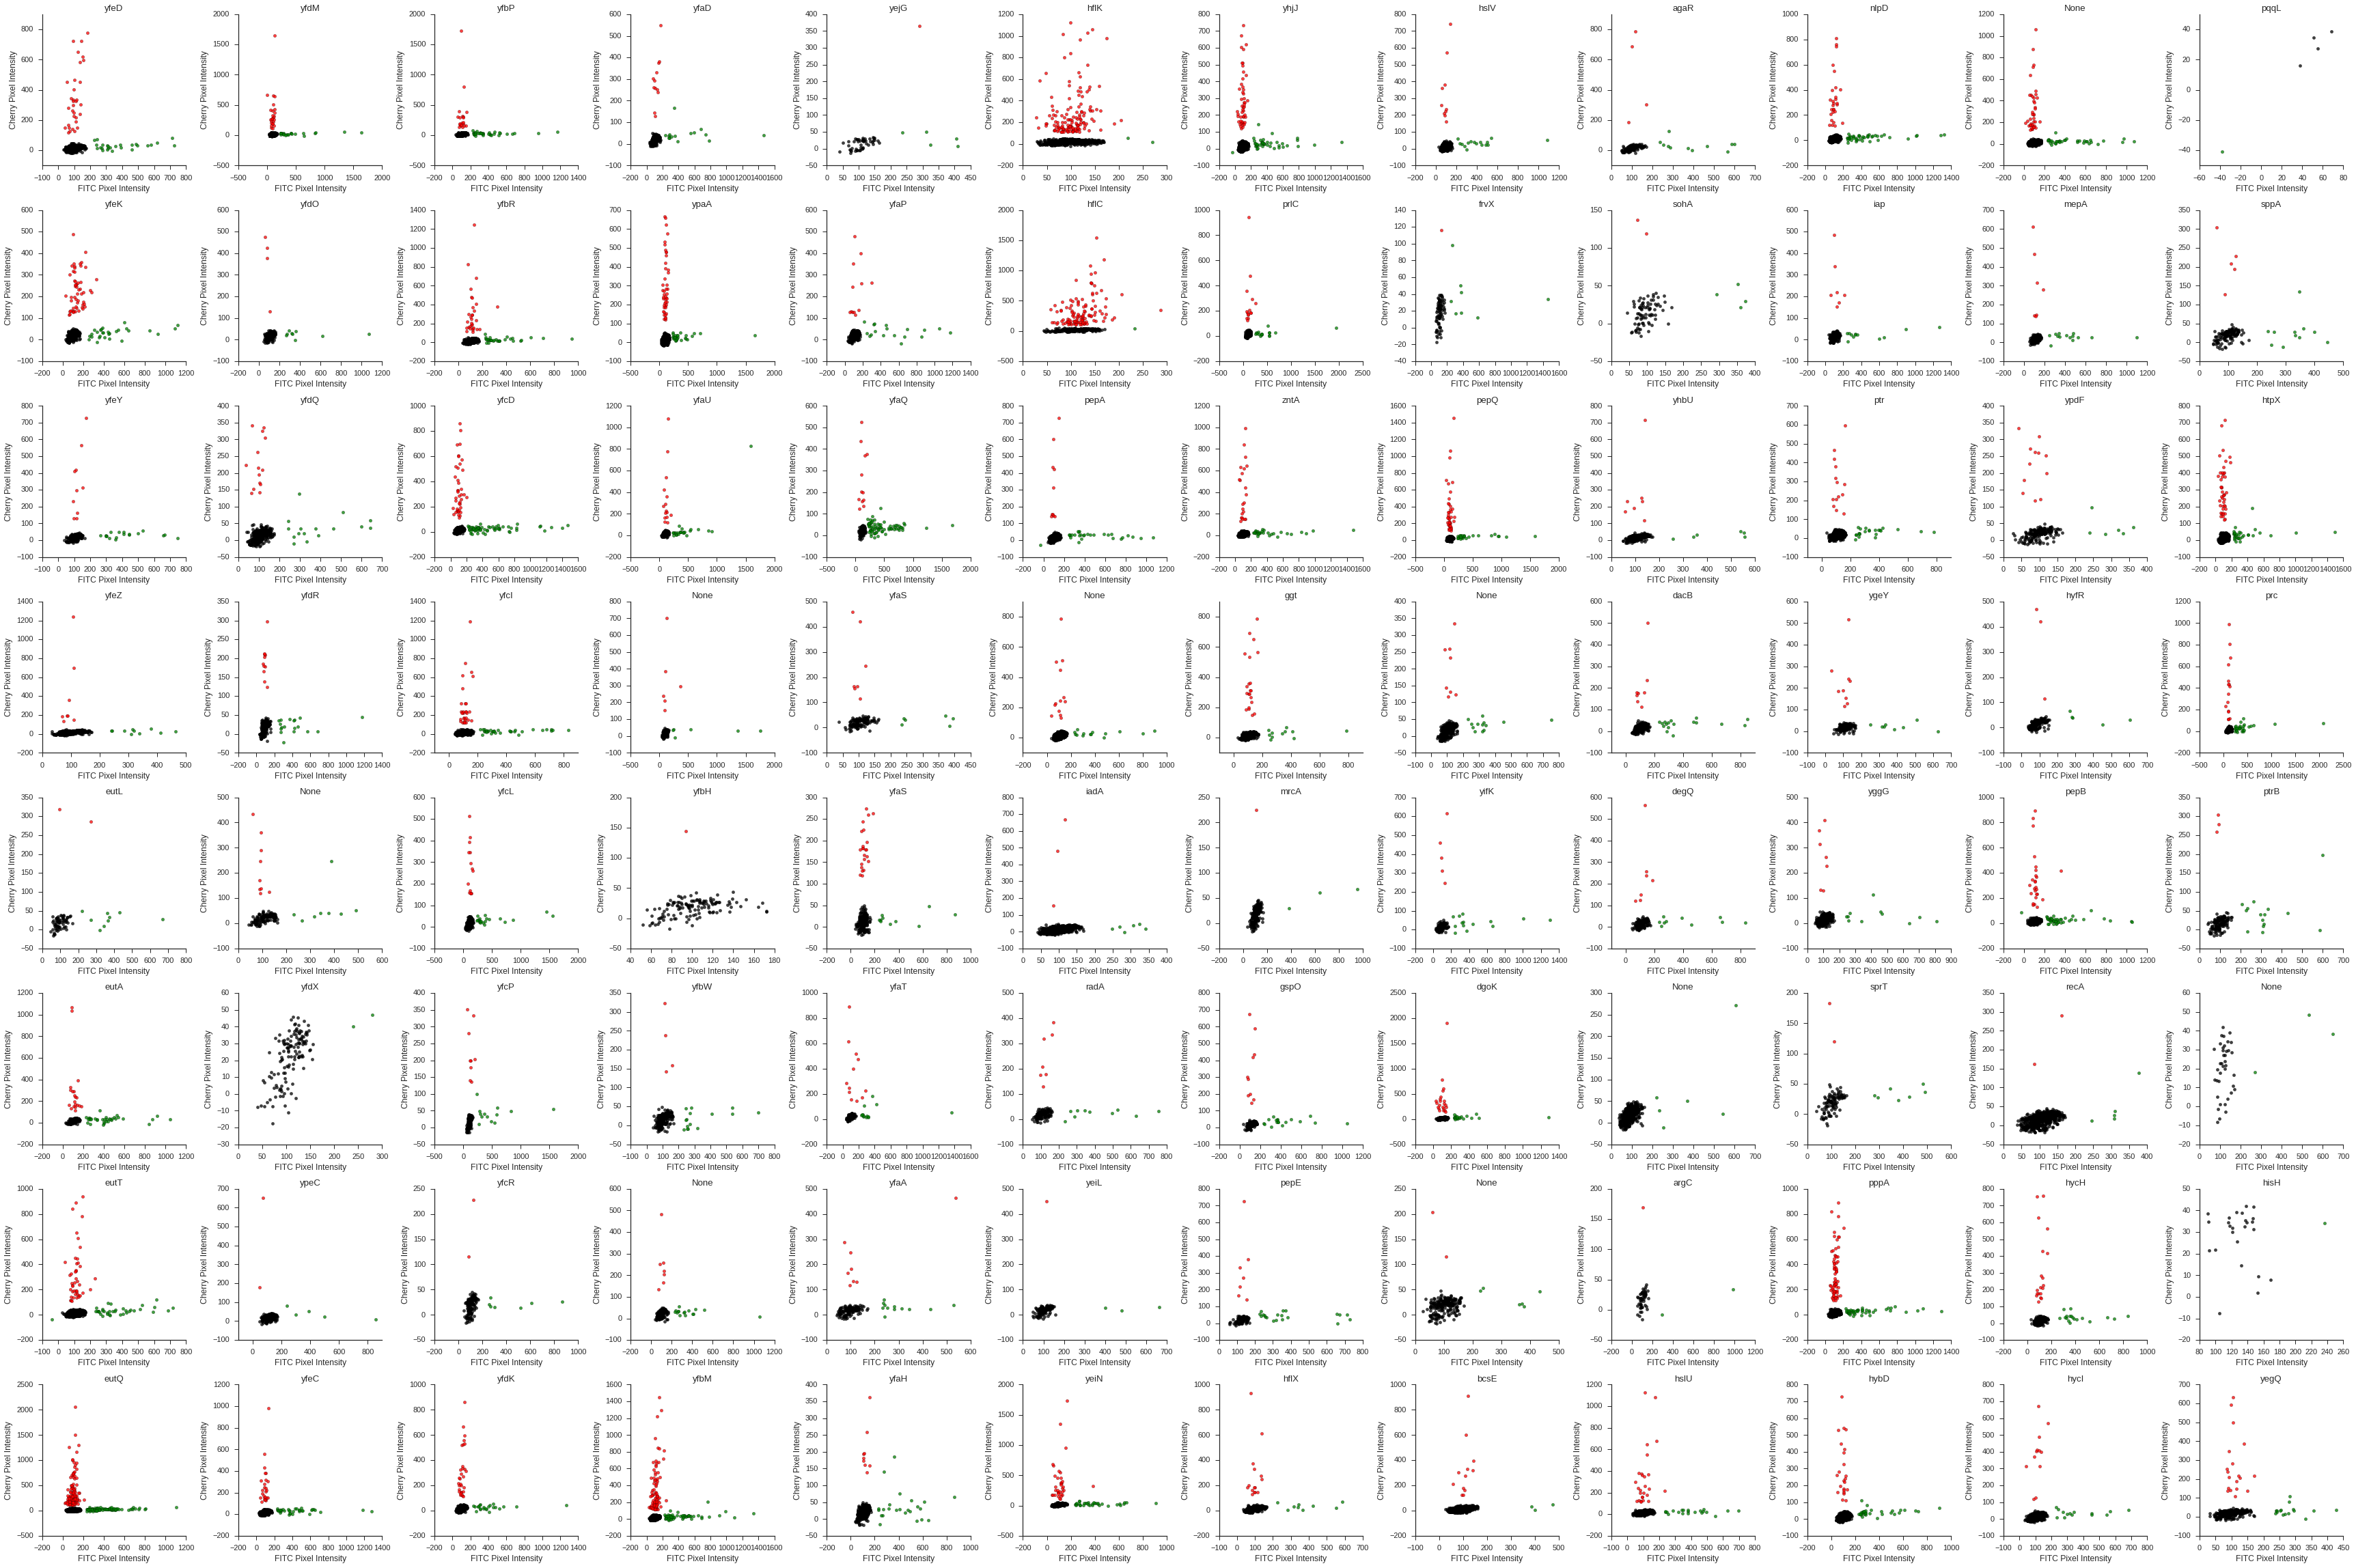

In [5]:
#Plot the scatter plot of intensities
wells = []
titles = []
keio_names_array = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        wells += [well]
        titles += [pos_to_strain(keio_names_array, plate_number, well)]
        
plot_slip_wells_gmm(mean_FITC, mean_cherry, wells = wells, titles = titles)
sns.despine()

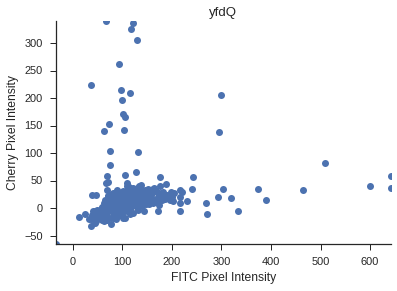

In [6]:
#Print specific wells
well = "C2"
fitc_list = np.array(mean_FITC[well])
cherry_list = np.array(mean_cherry[well])
fig = plt.figure()
plt.plot(fitc_list, cherry_list, 'o')
plt.xlabel('FITC Pixel Intensity')
plt.ylabel('Cherry Pixel Intensity')
plt.title(pos_to_strain(keio_names_array, plate_number, well))
xmax = max(fitc_list)
xmin = min(fitc_list)
ymax = max(cherry_list)
ymin = min(cherry_list)
plt.axis([xmin, xmax, ymin, ymax])
sns.despine()

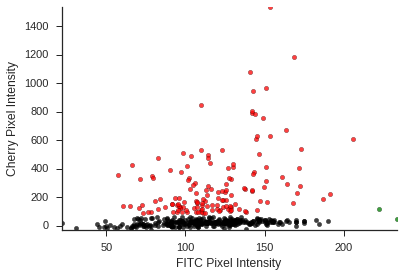

In [196]:
def classify_infections_gmm(fitc_dict, cherry_dict, wells):
	fitc_list = []
	cherry_list = []
	for well in wells:
		fitc_list += fitc_dict[well]
		cherry_list += cherry_dict[well]
	data = np.stack((fitc_list,cherry_list), axis = 1)

	gmm = mixture.GMM(n_components = 3).fit(data)

	#identify populations
	means = gmm.means_

	fitc_means = np.array([mean[0] for mean in means])
	cherry_means = np.array([mean[1] for mean in means])
	index_list = [0,1,2]
	lytic_id = np.argmax(fitc_means)
	lysogenic_id = np.argmax(cherry_means)
	index_list.remove(lytic_id)
	index_list.remove(lysogenic_id)
	uninfected_id = index_list[0]

	lytic_dict = {}
	lysogenic_dict = {}
	uninfected_dict = {}

	for well in wells:
		fitc_list = np.array(fitc_dict[well])
		cherry_list = np.array(cherry_dict[well])

		data_well = np.stack((fitc_list, cherry_list), axis = 1)
		probs = gmm.predict_proba(data_well)

		lytic_dict[well] = []
		lysogenic_dict[well] = []
		uninfected_dict[well] = []

		for j in xrange(data_well.shape[0]):
			if probs[j][lytic_id] > 0.75:
				lytic_dict[well] += [data_well[j,:]]
			if probs[j][lysogenic_id] > 0.75:
				lysogenic_dict[well] += [data_well[j,:]]
			if probs[j][uninfected_id] > 0.75:
				uninfected_dict[well] += [data_well[j,:]]

		lytic_dict[well] = np.array(lytic_dict[well])
		lysogenic_dict[well] = np.array(lysogenic_dict[well])
		uninfected_dict[well] = np.array(uninfected_dict[well])

	return lytic_dict, lysogenic_dict, uninfected_dict

lytic_dict, lysogenic_dict, uninfected_dict = classify_infections_gmm(mean_FITC, mean_cherry, wells = wells)

well = 'B6'
fig = plt.figure()
ax = plt.gca()
ax.scatter(lytic_dict[well][:,0], lytic_dict[well][:,1], c = 'g', alpha = 0.75)
ax.scatter(lysogenic_dict[well][:,0], lysogenic_dict[well][:,1], c = 'r', alpha = 0.75)
ax.scatter(uninfected_dict[well][:,0], uninfected_dict[well][:,1], c = 'k', alpha = 0.75)

# ax.scatter(mean_FITC[well], mean_cherry[well], c = colors)
plt.xlabel('FITC Pixel Intensity')
plt.ylabel('Cherry Pixel Intensity')
xmax = max(lytic_dict[well][:,0])
xmin = min(uninfected_dict[well][:,0])
ymax = max(lysogenic_dict[well][:,1])
ymin = min(uninfected_dict[well][:,1])
plt.axis([xmin, xmax, ymin, ymax])
sns.despine()

In [ ]:

#Print all wells
fitc_list = []
cherry_list = []
for row in row_data:
    for col in col_data:
        well = row + str(col)
        fitc_list += mean_FITC[well]
        cherry_list += mean_cherry[well]
        


from sklearn import mixture

data = np.stack((fitc_list,cherry_list), axis = 1)
print data.shape

gmm = mixture.GMM(n_components = 3).fit(data)
colors = []

well = 'A6'
data_test = np.stack((mean_FITC[well], mean_cherry[well]), axis = 1)
probs = gmm.predict_proba(data_test)
print gmm.means_
print probs
for i in gmm.predict(data_test):
    if i == 0:
        colors += ['r']
    if i == 1: 
        colors += ['g']
    if i == 2:
        colors += ['b']
    if i ==3:
        colors += ['c']
        
for i in xrange(len(colors)):
    if probs[i][0]>0.01:
        colors[i] = 'r' 

fig = plt.figure()
ax = plt.gca()
ax.scatter(data_test[:,0], data_test[:,1], c = colors, alpha = 0.5)
# ax.scatter(mean_FITC[well], mean_cherry[well], c = colors)
plt.xlabel('FITC Pixel Intensity')
plt.ylabel('Cherry Pixel Intensity')
xmax = max(fitc_list)
xmin = min(fitc_list)
ymax = max(cherry_list)
ymin = min(cherry_list)
plt.axis([xmin, xmax, ymin, ymax])
sns.despine()


In [17]:
#Print the number of cells in each well
for key in mean_FITC_control.keys():
    print key, len(mean_FITC_control[key])
    
for key in mean_FITC.keys():
    print key, len(mean_FITC[key])

A12 3690
G7 167
G6 134
G5 184
G4 219
G3 172
G2 213
G1 892
G9 59
G8 268
B4 1082
B5 387
B6 473
B7 427
B1 466
B2 251
B3 929
B8 106
B9 102
E9 189
E8 179
E5 296
E4 138
E7 213
E6 910
E1 96
E3 469
E2 164
H10 857
H11 822
H12 346
F12 48
F10 127
F11 630
H8 1381
H9 490
H2 647
H3 589
H1 1905
H6 510
H7 410
H4 1462
H5 407
D10 194
D11 197
D12 369
B12 140
B10 222
B11 193
C9 239
C8 390
C3 620
C2 428
C1 193
C7 593
C6 354
C5 358
C4 517
G12 36
G11 293
G10 1391
F1 391
F2 146
F3 154
F4 247
F5 158
F6 150
F7 192
F8 462
F9 485
E11 416
E10 336
E12 169
C12 664
C11 208
C10 441
A11 939
A10 615
A12 7
A1 688
A3 697
A2 897
A5 65
A4 301
A7 1011
A6 840
A9 179
A8 394
D8 372
D9 264
D6 433
D7 458
D4 152
D5 149
D2 276
D3 581
D1 361


In [18]:
# Fit a KDE estimator to the no infection control
kernel = fit_kde(mean_FITC_control, mean_cherry_control, 'A12')

In [19]:
#Compute the fraction infected in each well and plot
conc_list = []
fraction_infected_list = []
for well in p_values_dict.keys():
    p_value = p_values_dict[well]
    fraction_infected = np.float(np.where(p_value < 0.01)[0].shape[0])/np.float(p_value.shape[0])
    fraction_infected_list += [fraction_infected]
    
    print well, fraction_infected

G7 0.766467065868
G6 0.485074626866
G5 0.527173913043
G4 0.675799086758
G3 0.53488372093
G2 0.586854460094
G1 0.47197309417
G9 0.508474576271
G8 0.514925373134
B4 0.558225508318
B5 0.576227390181
B6 0.733615221987
B7 0.587822014052
B1 0.671673819742
B2 0.557768924303
B3 0.56727664155
B8 0.575471698113
B9 0.43137254902
E9 0.544973544974
E8 0.513966480447
E5 0.432432432432
E4 0.471014492754
E7 0.521126760563
E6 0.413186813187
E1 0.552083333333
E3 0.620469083156
E2 0.658536585366
H10 0.462077012835
H11 0.484184914842
H12 0.589595375723
F12 0.625
F10 0.511811023622
F11 0.450793650794
H8 0.354815351195
H9 0.526530612245
H2 0.576506955178
H3 0.589134125637
H1 0.500262467192
H6 0.576470588235
H7 0.521951219512
H4 0.651846785226
H5 0.641277641278
D10 0.536082474227
D11 0.370558375635
D12 0.574525745257
B12 0.507142857143
B10 0.522522522523
B11 0.621761658031
C9 0.52719665272
C8 0.617948717949
C3 0.572580645161
C2 0.476635514019
C1 0.59585492228
C7 0.470489038786
C6 0.483050847458
C5 0.80726256

yfeD 11 35
yfdM 12 39
yfbP 12 31
yfaD 3 15
yejG 2 1
hflK 4 239
yhjJ 19 67
hslV 6 19
agaR 2 8
nlpD 17 37
None 13 55
yfeK 10 50
yfdO 3 6
yfbR 12 40
ypaA 13 63
yfaP 7 14
hflC 1 134
prlC 6 18
frvX 4 3
sohA 1 3
iap 6 10
mepA 2 6
sppA 6 5
yfeY 4 14
yfdQ 8 17
yfcD 18 45
yfaU 7 18
yfaQ 13 15
pepA 7 13
zntA 8 25
pepQ 2 44
yhbU 2 7
ptr 8 23
ypdF 1 18
htpX 13 57
yfeZ 4 17
yfdR 8 21
yfcI 10 32
None 1 6
yfaS 3 7
None 6 16
ggt 7 23
None 4 17
dacB 4 11
ygeY 3 8
hyfR 1 3
prc 10 16
eutL 2 4
None 4 11
yfcL 7 17
yfbH 4 1
yfaS 5 50
iadA 1 3
mrcA 0 3
yifK 4 8
degQ 4 6
yggG 5 10
pepB 15 29
ptrB 8 8
eutA 14 25
yfcP 4 7
yfbW 9 7
yfaT 1 6
radA 3 5
gspO 3 8
dgoK 6 28
None 2 7
sprT 2 5
recA 3 2
None 0 1
eutT 18 49
ypeC 2 7
yfcR 1 4
None 5 10
yfaA 4 10
yeiL 1 3
pepE 5 5
None 3 5
argC 1 2
pppA 17 78
hycH 5 19
hisH 0 1
eutQ 24 185
yfeC 9 39
yfdK 4 36
yfbM 24 102
yfaH 11 16
yeiN 13 38
hflX 3 18
bcsE 2 15
hslU 9 42
hybD 5 35
hycI 5 11
yegQ 8 27


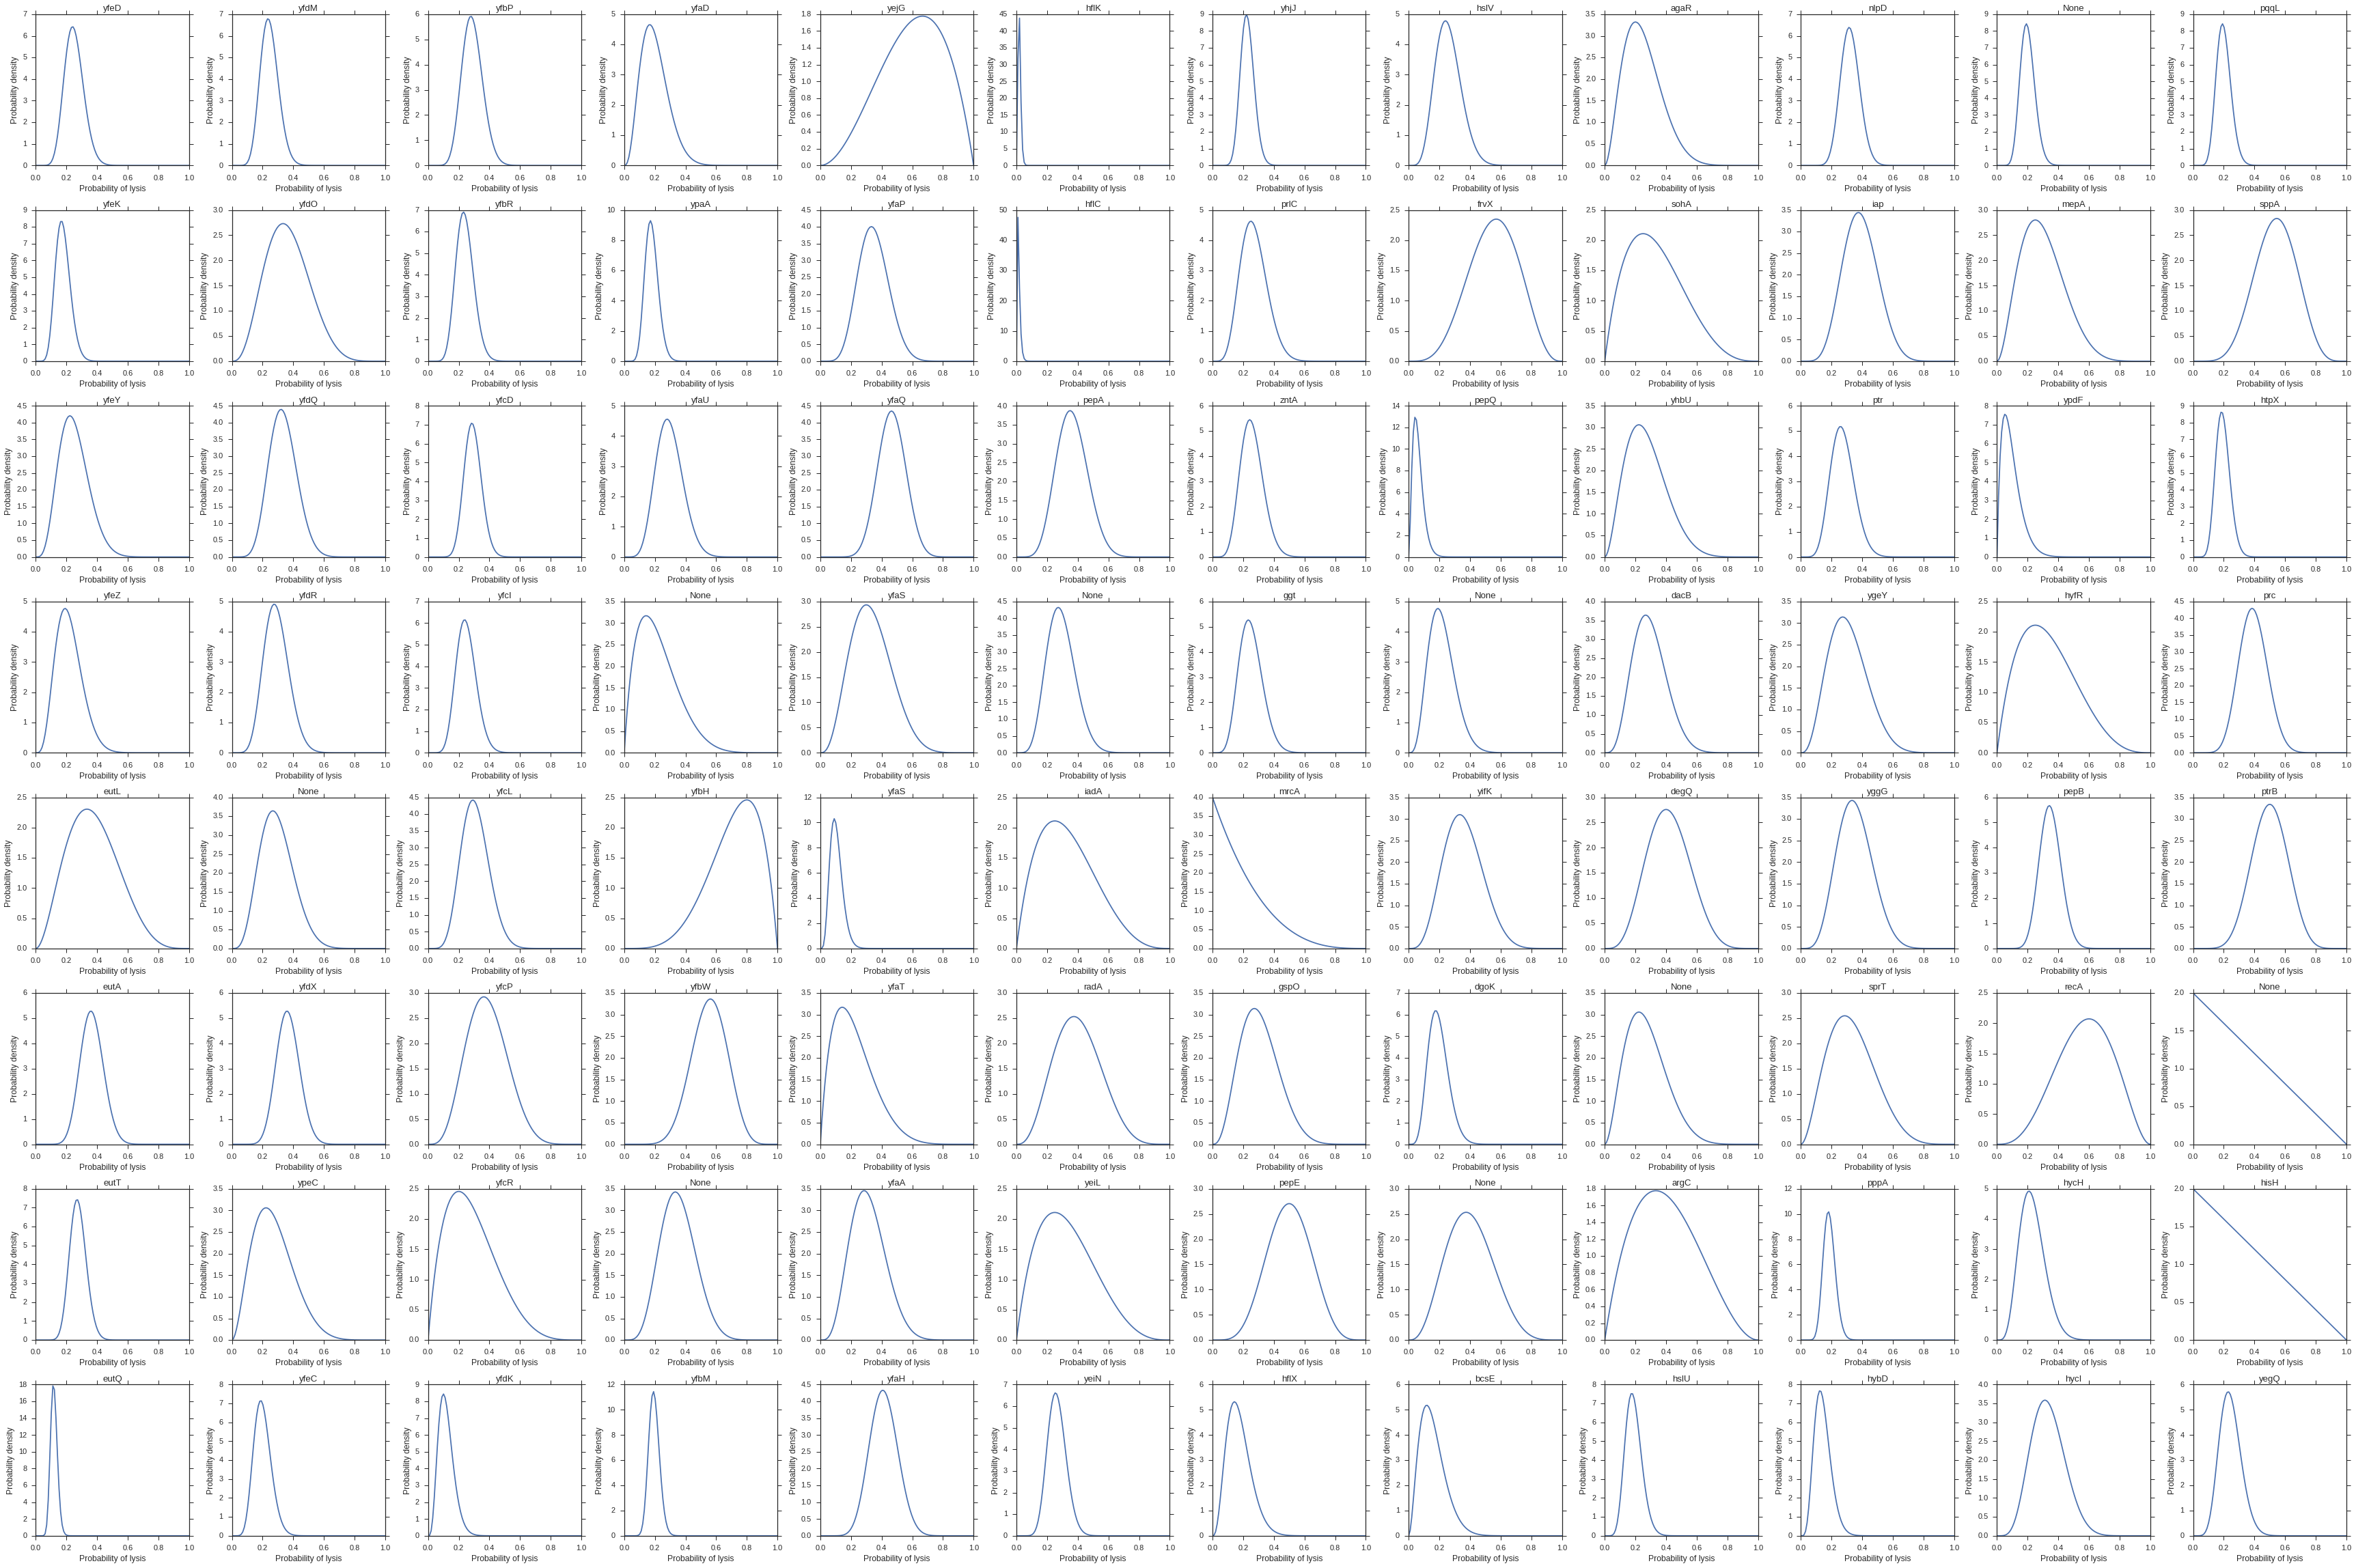

In [15]:
# Use the no phage control to construct a lysis/lysogeny classifier
fitc_control_array = np.array(mean_FITC_control['A12'])
cherry_control_array = np.array(mean_cherry_control['A12'])
kernel_fitc = scipy.stats.gaussian_kde(fitc_control_array)
kernel_cherry = scipy.stats.gaussian_kde(cherry_control_array)

def compute_p_lysis_posterior(N_lysis, N_lysogeny):
    x = np.linspace(0,1,100)
    posterior= scipy.stats.beta.pdf(x, 1+N_lysis, 1+N_lysogeny)
    return x, posterior

# d = classify_infections(kernel_fitc, kernel_cherry, p_values_dict, rows = row_data, cols = col_data)

kn = get_keio_names()
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        d = {'FITC Probability': p_fitc, 'Cherry Probability': p_cherry}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Probability', 'Cherry Probability', dataframe, fit_reg = False)
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)
#         ax.set_xlim([-0.05, 1.05])
#         ax.set_ylim([-0.05, 1.05])

        d = {'FITC Intensity': fitc_list, 'Cherry Intensity': cherry_list}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Intensity', 'Cherry Intensity', dataframe, fit_reg = False, scatter_kws = {'color': 'red'})
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            print well_name, counter, len(p_fitc)-counter
            x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()
    

hflC 1 134


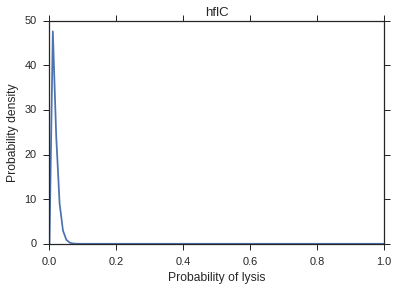

In [18]:
well = "B6"
        
well_name = pos_to_strain(kn, plate = plate_number, pos = well)
p_value = p_values_dict[well]
infected_cells = np.where(p_value < 0.01)[0]
fitc_list = np.array(mean_FITC[well])[infected_cells]
cherry_list = np.array(mean_cherry[well])[infected_cells]

p_fitc = []
p_cherry = []
for fitc, cherry in zip(fitc_list, cherry_list):
    p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
    p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

# Remove double positives
p_fitc_new = []
p_cherry_new = []
fitc_list_new = []
cherry_list_new = []
for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
    if (p_f < 0.85 and c > 50) or p_c < 0.85:
        p_fitc_new += [p_f]
        p_cherry_new += [p_c]
        fitc_list_new += [f]
        cherry_list_new += [c]

p_fitc = p_fitc_new
p_cherry = p_cherry_new
fitc_list = fitc_list_new
cherry_list = cherry_list_new

counter = 0
for p_f, p_c in zip(p_fitc, p_cherry):
    if p_f > p_c:
        counter += 1
                
if len(p_fitc) > 0:
    #Uncomment to print p_lysis
    #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
    print well_name, counter, len(p_fitc)-counter
    x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)

    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1
    fig = plt.figure()
    axes = plt.gca()
    axes.plot(x, posterior)
    axes.set_xlim([0, 1])
    axes.set_xlabel('Probability of lysis')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)

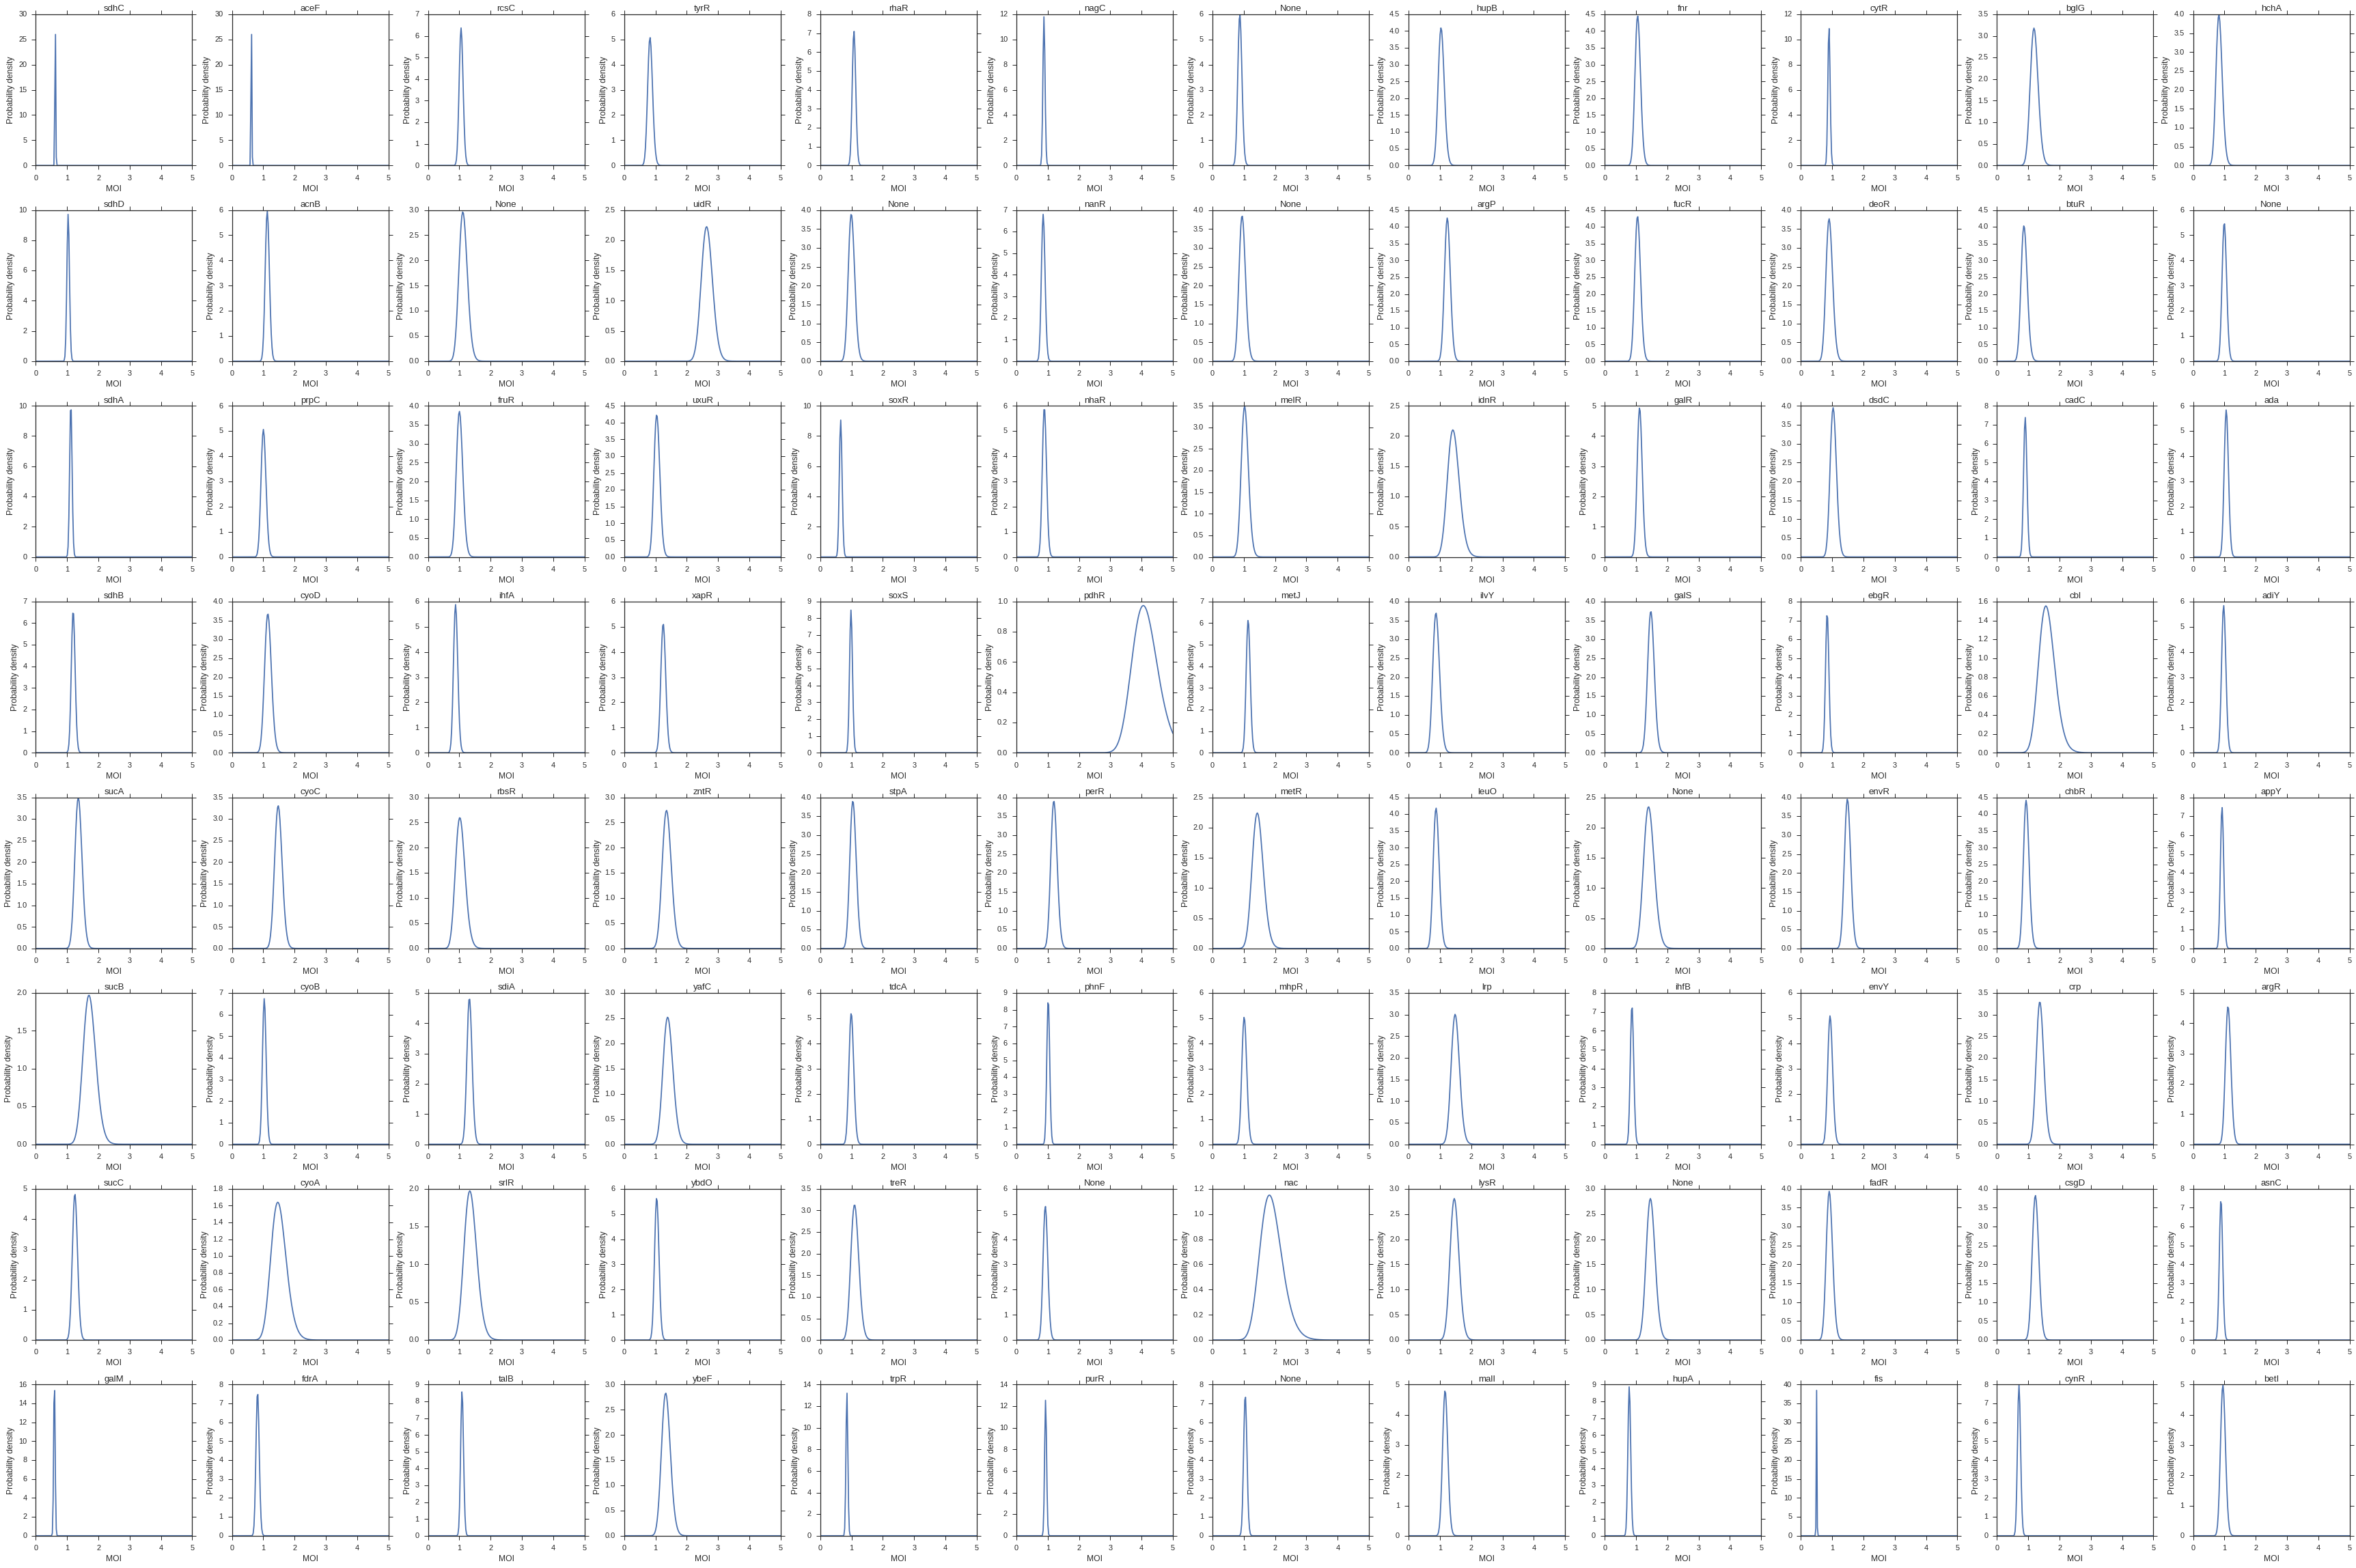

In [22]:
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,5,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 5])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 5])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()

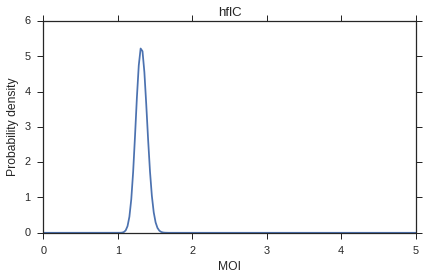

In [20]:
fig = plt.figure()
axes = plt.gca()

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,5,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

well = "B6"
        
well_name = pos_to_strain(kn, plate = plate_number, pos = well)
p_value = p_values_dict[well]
infected_cells = np.where(p_value < 0.01)[0]
fitc_list = np.array(mean_FITC[well])[infected_cells]
cherry_list = np.array(mean_cherry[well])[infected_cells]

p_fitc = []
p_cherry = []
for fitc, cherry in zip(fitc_list, cherry_list):
    p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
    p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

# Remove double positives
p_fitc_new = []
p_cherry_new = []
fitc_list_new = []
cherry_list_new = []
for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
    if (p_f < 0.85 and c > 50) or p_c < 0.85:
        p_fitc_new += [p_f]
        p_cherry_new += [p_c]
        fitc_list_new += [f]
        cherry_list_new += [c]

p_fitc = p_fitc_new
p_cherry = p_cherry_new
fitc_list = fitc_list_new
cherry_list = cherry_list_new

counter = 0
for p_f, p_c in zip(p_fitc, p_cherry):
    if p_f > p_c:
        counter += 1

if len(p_fitc) > 0:
    #Uncomment to print p_lysis
    #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
    x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])

    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1

    axes.plot(x, posterior)
    axes.set_xlim([0, 5])
    axes.set_xlabel('MOI')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)
else:    
    alphabet = ['A','B','C','D','E','F','G','H']
    chars = list(well)
    row_temp = alphabet.index(chars[0])
    if len(chars) == 2:
        col_temp = int(chars[1])-1
    if len(chars) == 3:
        col_temp = int(chars[1] + chars[2])-1

    axes.plot(x, posterior)
    axes.set_xlim([0, 5])
    axes.set_xlabel('MOI')
    axes.set_ylabel('Probability density')
    axes.set_title(well_name)
            
plt.tight_layout()